# Subreddit Classification - Data Cleaning and EDA

### Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import time
import warnings
import regex as re

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

from nltk.sentiment.vader import SentimentIntensityAnalyzer
warnings.filterwarnings('ignore')
np.random.seed(824)
from bs4 import BeautifulSoup 

# Import stopwords.
from nltk.corpus import stopwords # Import the stopword list
import nltk

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('fivethirtyeight')

## Data Cleaning

### Open raw data dataframe

In [2]:
df = pd.read_csv('../datasets/combined_raw_data.csv')

In [3]:
df.drop(columns = 'Unnamed: 0', inplace = True)

In [4]:
df.head()

,title,selftext,subreddit
0,7 rules for surviving The Crack,"“We have to rewrite it, there is no other poss...",1
1,I was followed home one night and got a tape t...,It was a warm night in a town just outside of ...,1
2,Don't go looking for the door... or you'll fin...,[PART ONE](https://www.reddit.com/r/nosleep/co...,1
3,"i am a prisoner at a special security prison, ...",I am a prisoner at a special security prison ....,1
4,"my friend told me a scary story 10 years ago, ...","About 10 years ago, on this day, this happened...",1


In [5]:
df.shape

(20000, 3)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      20000 non-null  object
 1   selftext   18237 non-null  object
 2   subreddit  20000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 468.9+ KB


### Check for missing values

In [7]:
df.isnull().sum()

title           0
selftext     1763
subreddit       0
dtype: int64

### Replacing missing values in selftext column:
- **Imputing 'NoText' in place of NaN, which will be added to custom stopwords list later on**

In [8]:
df[df['selftext'].isnull()]

,title,selftext,subreddit
138,Exciting an electron in one place/death of Inn...,NaN,1
147,8 years ago my elementary school had a lockdow...,NaN,1
148,Pop Goes The Weasel,NaN,1
160,Something touched me inappropriately,NaN,1
164,"If I'm Not On The Road, The ""Rules of the Road...",NaN,1
...,...,...,...
19983,The pic i promised.,NaN,0
19984,Pic that i promised.,NaN,0
19985,This is my uncle's recording at night. You guy...,NaN,0
19992,HALLOWEEN NIGHTMARE,NaN,0


In [9]:
df.fillna('NoText', inplace = True)

In [10]:
df.isnull().sum()

title        0
selftext     0
subreddit    0
dtype: int64

## Exploratory Data Analysis

### Create columns for title character and word counts

In [11]:
df['title_char_count'] = df.title.map(len)

In [12]:
df['title_word_count'] = df.title.map(lambda x: len(x.split()))

### Create columns for selftext character and word counts

In [13]:
df['selftext_char_count'] = df.selftext.map(len)

In [14]:
df['selftext_word_count'] = df.selftext.map(lambda x: len(x.split()))

### Summary Statistics for all data

In [15]:
df.describe()

,subreddit,title_char_count,title_word_count,selftext_char_count,selftext_word_count
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,0.500000,36.522400,6.917700,4304.077600,807.671550
std,0.500013,30.297236,5.861156,6022.623735,1111.643608
min,0.000000,1.000000,1.000000,2.000000,1.000000
25%,0.000000,17.000000,3.000000,238.750000,45.000000
50%,0.500000,28.000000,5.000000,2217.000000,437.000000
75%,1.000000,46.000000,9.000000,5587.000000,1054.000000
max,1.000000,300.000000,68.000000,40010.000000,7803.000000


### Summary Statistics for nosleep data

In [16]:
df[df['subreddit'] == 1].describe()

,subreddit,title_char_count,title_word_count,selftext_char_count,selftext_word_count
count,10000.0,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.0,41.38130,7.927600,6397.416000,1188.651100
std,0.0,29.14416,5.649208,7289.538304,1343.729053
min,1.0,1.00000,1.000000,2.000000,1.000000
25%,1.0,20.00000,4.000000,9.000000,1.000000
50%,1.0,34.00000,6.000000,4423.000000,833.000000
75%,1.0,56.00000,11.000000,9076.500000,1689.500000
max,1.0,300.00000,59.000000,40010.000000,7803.000000


### Summary Statistics for scarystories data

In [17]:
df[df['subreddit'] == 0].describe()

,subreddit,title_char_count,title_word_count,selftext_char_count,selftext_word_count
count,10000.0,10000.000000,10000.000000,10000.000000,10000.00000
mean,0.0,31.663500,5.907800,2210.739200,426.69200
std,0.0,30.648527,5.895437,3262.705068,612.94288
min,0.0,1.000000,1.000000,2.000000,1.00000
25%,0.0,15.000000,3.000000,405.750000,80.00000
50%,0.0,24.000000,4.000000,1291.000000,257.00000
75%,0.0,37.000000,7.000000,2657.000000,519.00000
max,0.0,300.000000,68.000000,38768.000000,7000.00000


### Looking into Title:

#### Visualization of Raw Title Character Counts

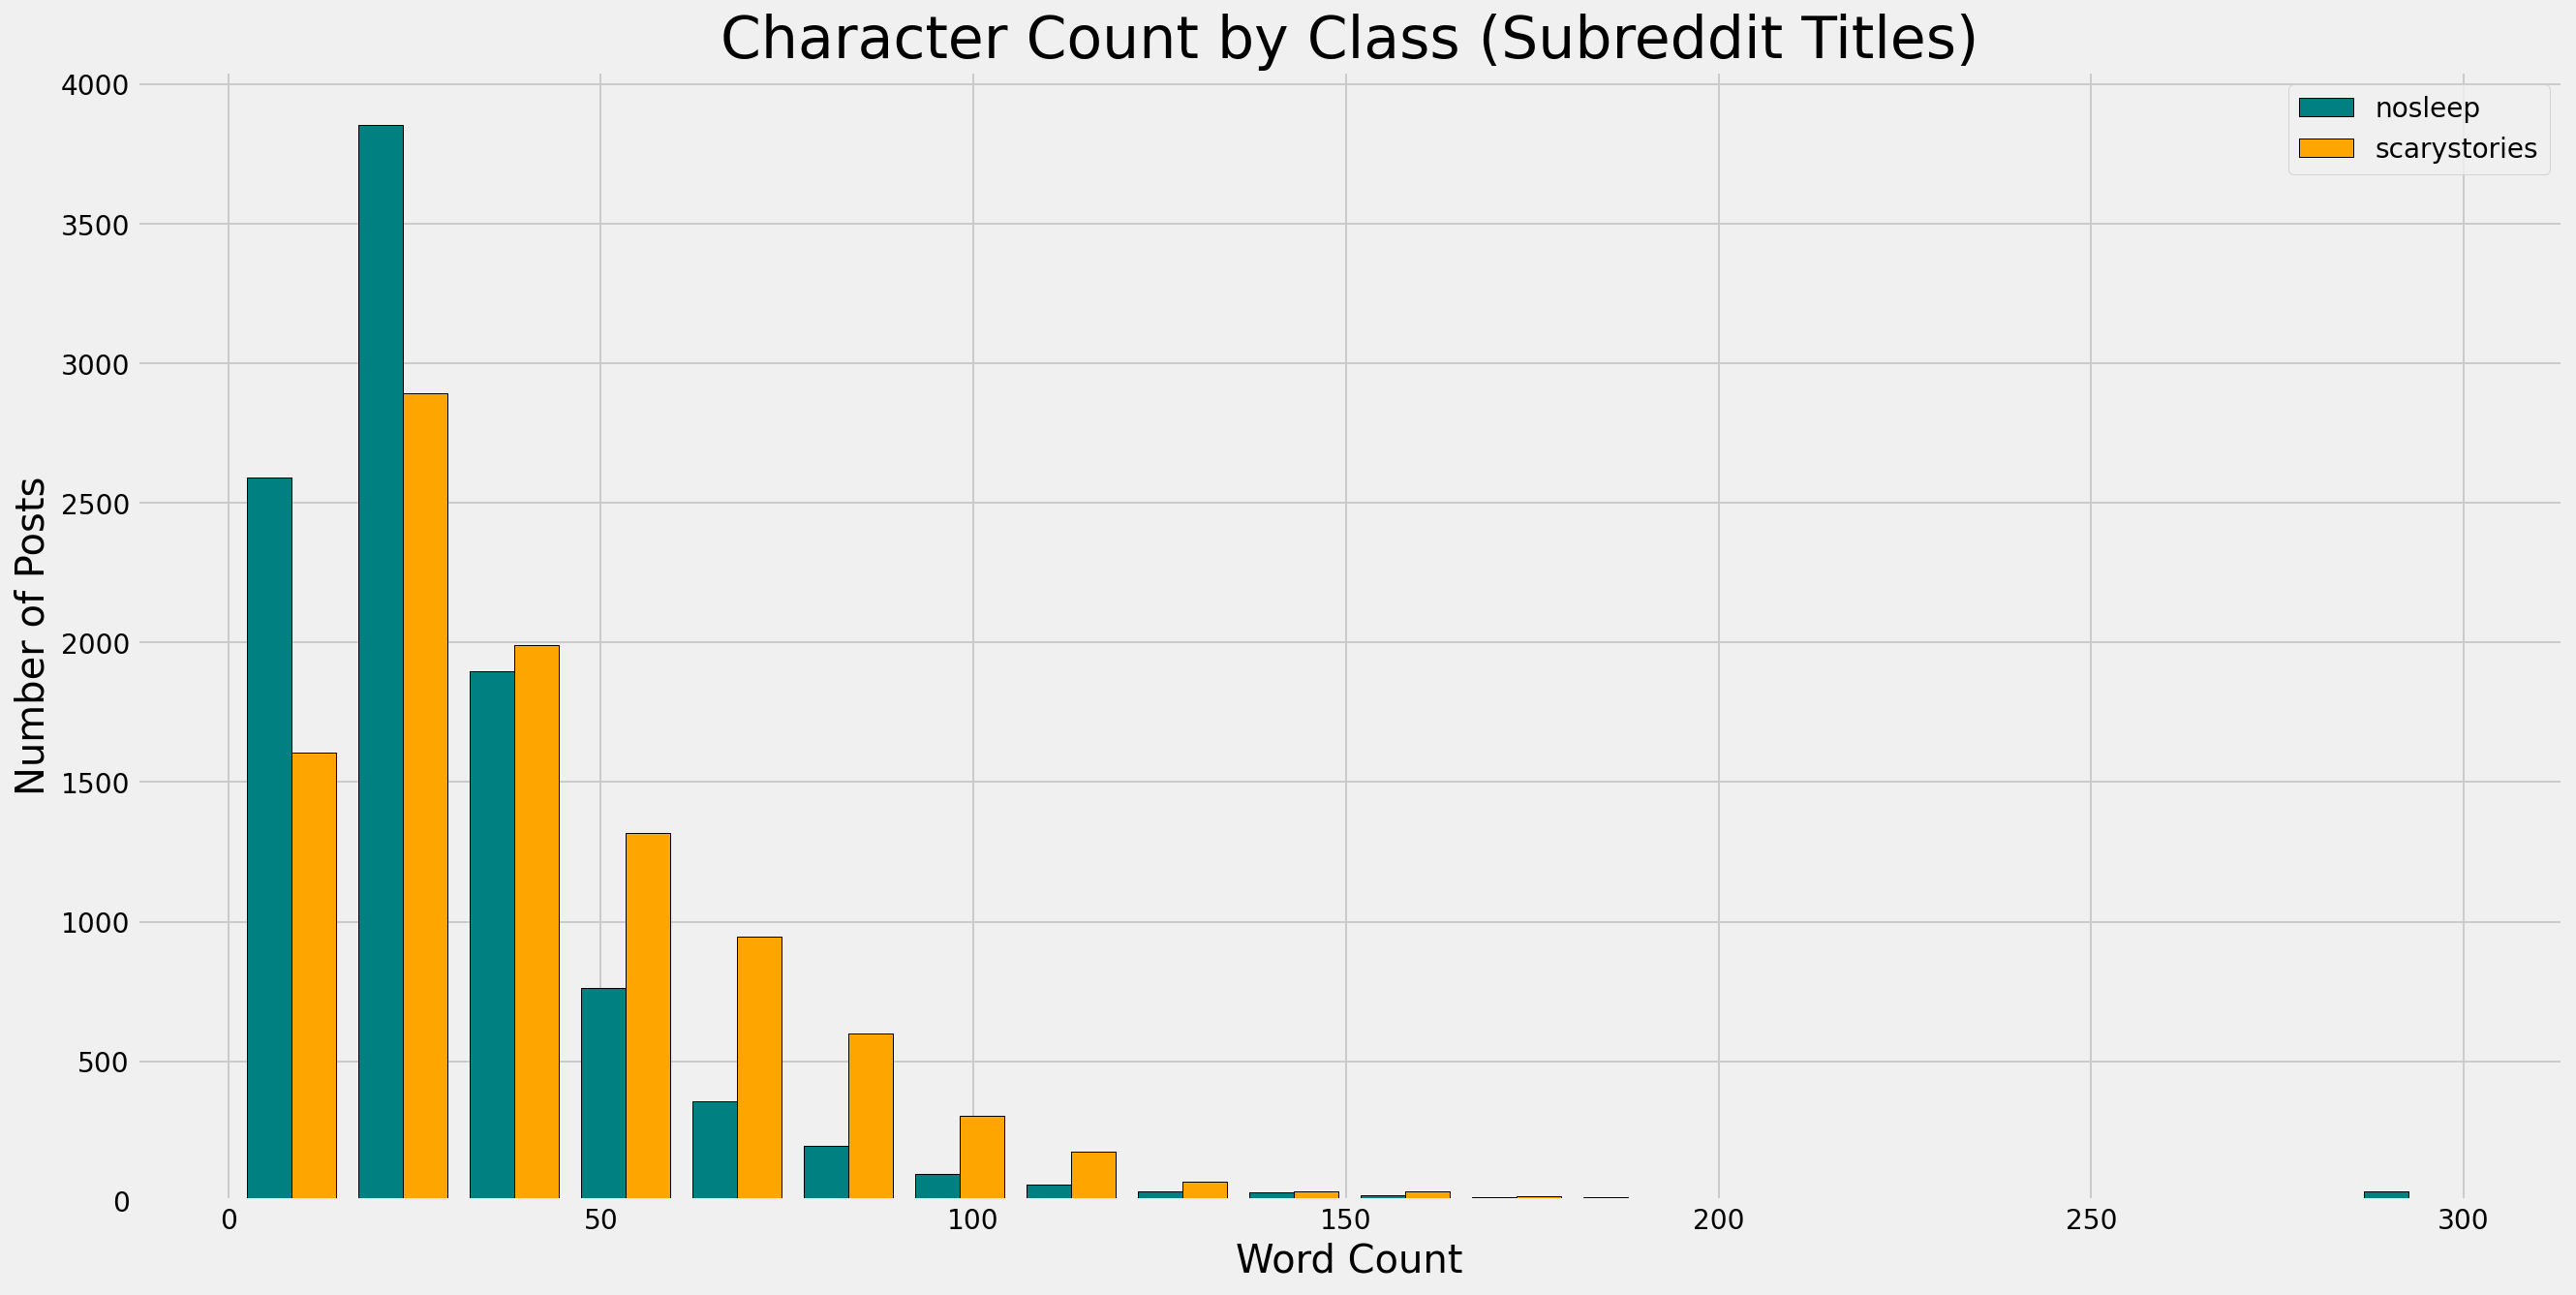

In [18]:
plt.figure(figsize=(20,10))
plt.hist([df[df['subreddit']==0]['title_char_count'], 
          df[df['subreddit']==1]['title_char_count']],
         bins=20, color=['teal', 'orange'], ec='k')
plt.title('Character Count by Class (Subreddit Titles)', fontsize=30)
plt.legend(['nosleep', 'scarystories']);

plt.xlabel('Word Count', fontsize=20)
plt.ylabel('Number of Posts', fontsize=20)

plt.savefig('../assets/raw_title_charcount', bbox_inches='tight', dpi = 235);

**Discription: Character count distribution of raw subreddit titles separated by class (nosleep or scarystories)**

#### Visualization of Raw Title Word Counts

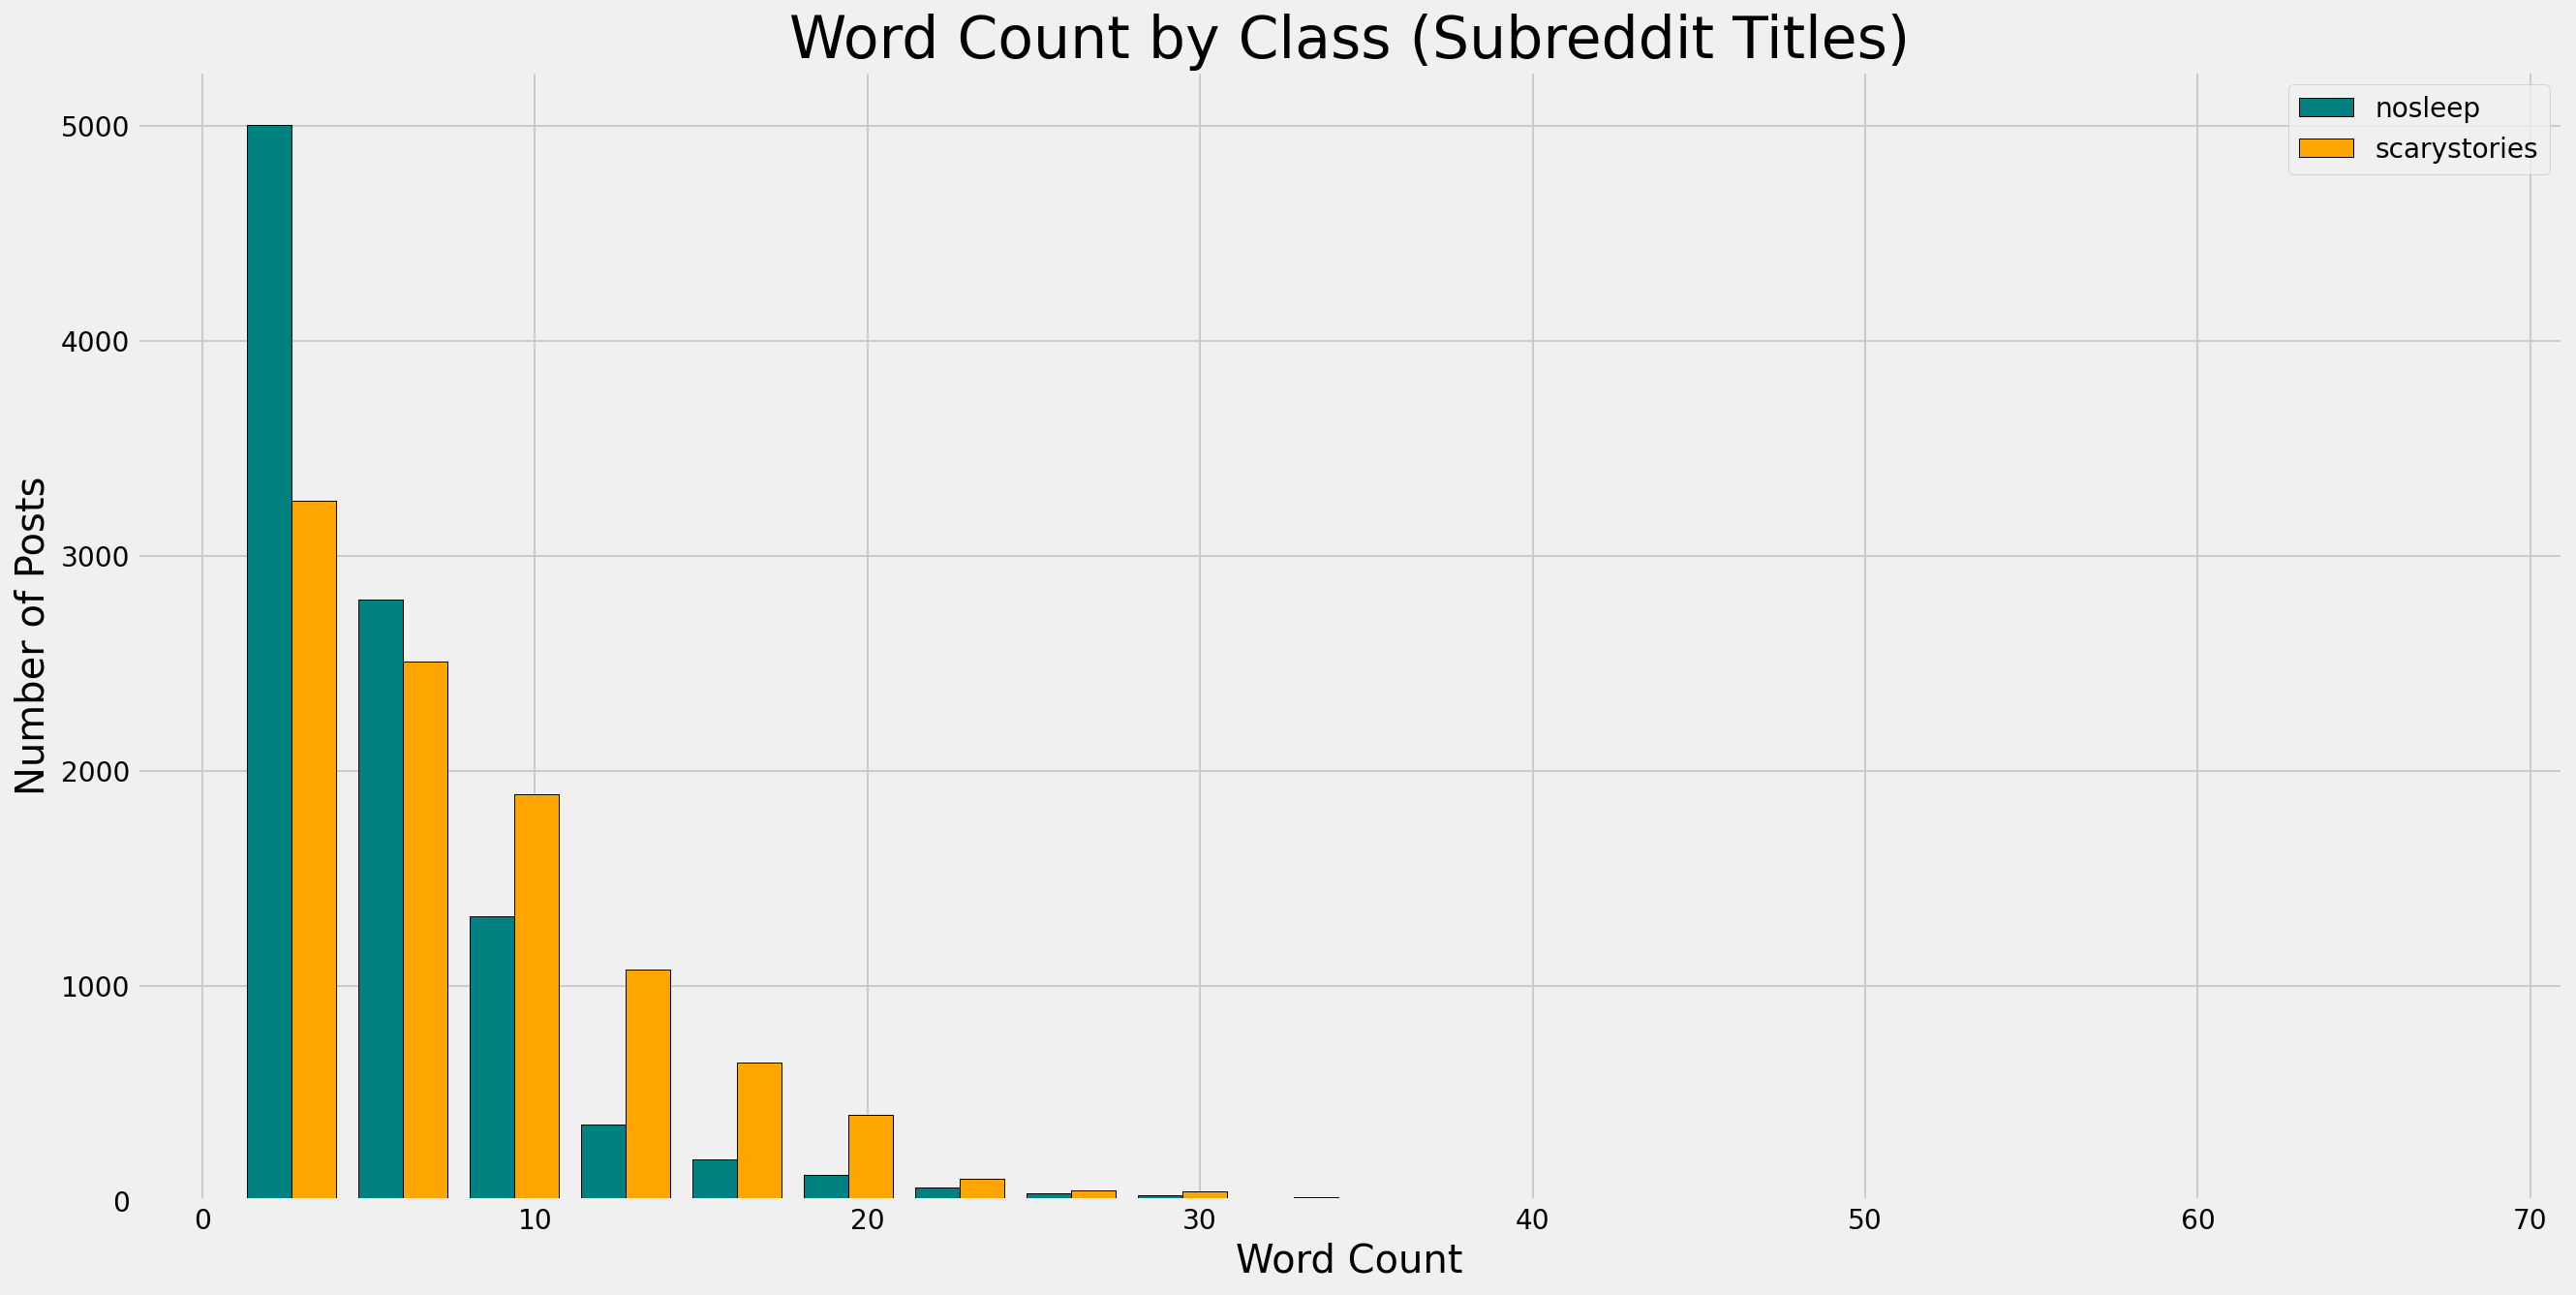

In [19]:
plt.figure(figsize=(20,10))
plt.hist([df[df['subreddit']==0]['title_word_count'], 
          df[df['subreddit']==1]['title_word_count']],
         bins=20, color=['teal', 'orange'], ec='k')
plt.title('Word Count by Class (Subreddit Titles)', fontsize=30)
plt.legend(['nosleep', 'scarystories'])

plt.xlabel('Word Count', fontsize=20)
plt.ylabel('Number of Posts', fontsize=20)

plt.savefig('../assets/raw_title_wordcount', bbox_inches='tight', dpi = 235);

**Discription: Word count distribution of raw subreddit titles separated by class (nosleep or scarystories)**

### Looking into Selftext:

#### Visualization of Raw Selftext Character Counts

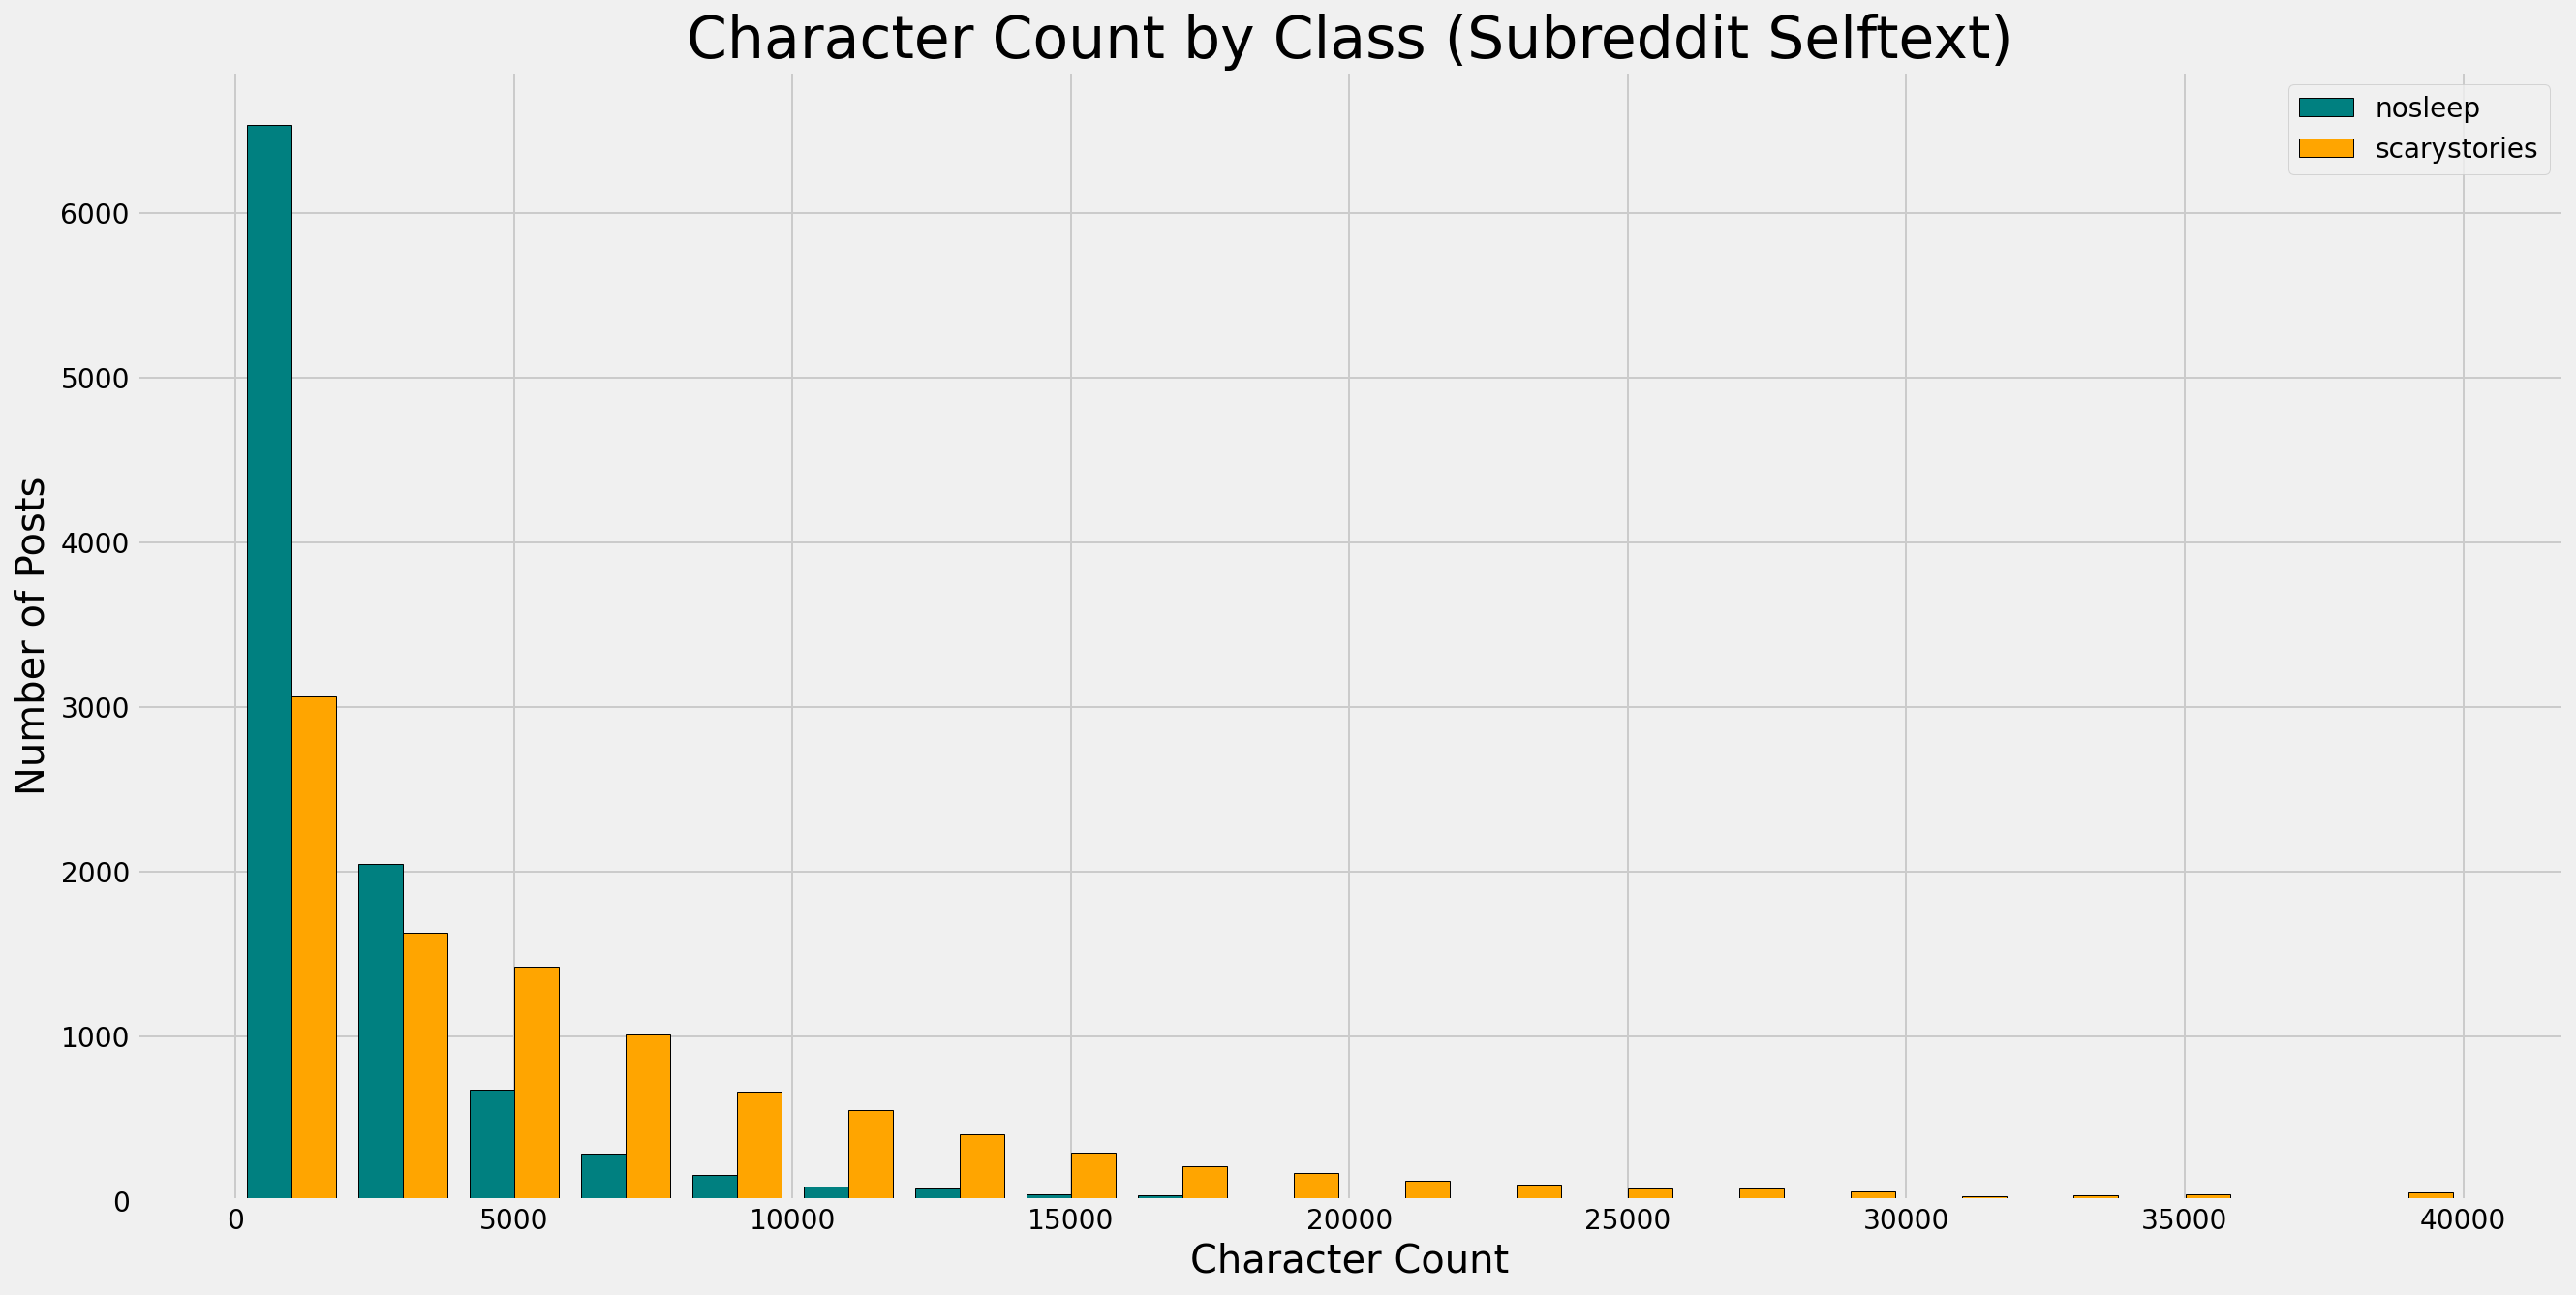

In [20]:
plt.figure(figsize=(20,10))
plt.hist([df[df['subreddit']==0]['selftext_char_count'], 
          df[df['subreddit']==1]['selftext_char_count']],
         bins=20, color=['teal', 'orange'], ec='k')
plt.title('Character Count by Class (Subreddit Selftext)', fontsize=30)
plt.legend(['nosleep', 'scarystories'])

plt.xlabel('Character Count', fontsize=20)
plt.ylabel('Number of Posts', fontsize=20)

plt.savefig('../assets/raw_selftext_charcount', bbox_inches='tight', dpi = 235);

**Discription: Character count distribution of raw subreddit sleftext separated by class (nosleep or scarystories)**

#### Visualization of Raw Selftext Word Counts

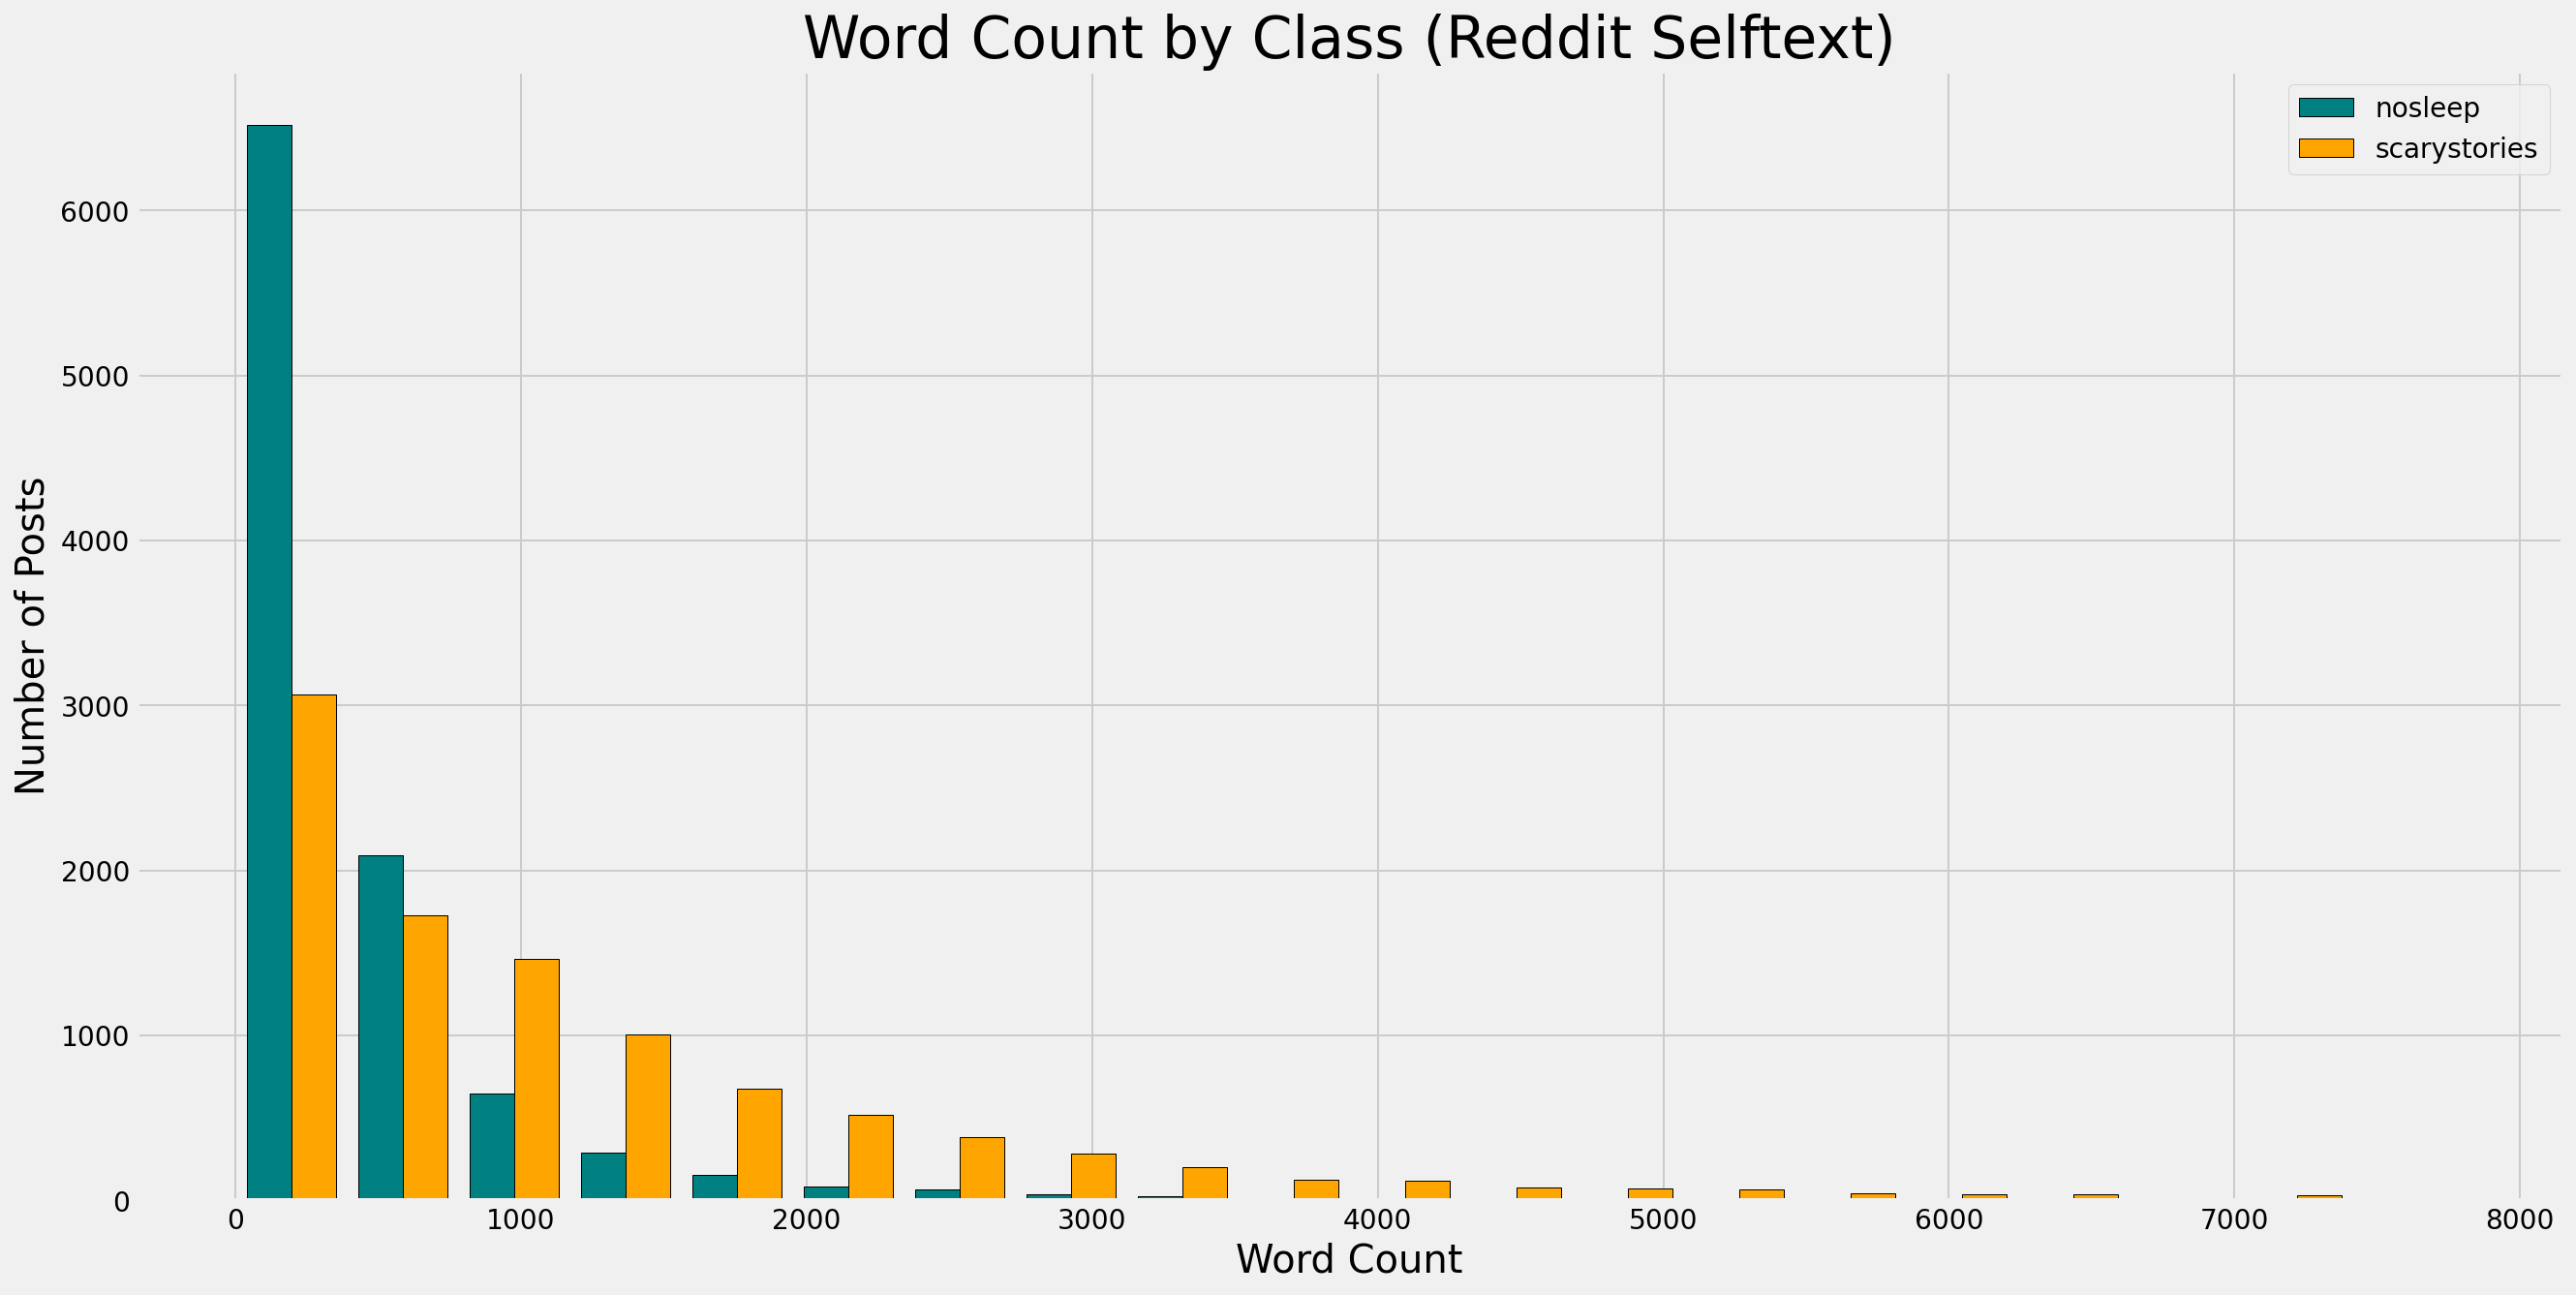

In [21]:
plt.figure(figsize=(20,10))
plt.hist([df[df['subreddit']==0]['selftext_word_count'], 
          df[df['subreddit']==1]['selftext_word_count']],
         bins=20, color=['teal', 'orange'], ec='k')
plt.title('Word Count by Class (Reddit Selftext)', fontsize=30)
plt.legend(['nosleep', 'scarystories'])

plt.xlabel('Word Count', fontsize=20)
plt.ylabel('Number of Posts', fontsize=20)

plt.savefig('../assets/raw_selftext_wordcount', bbox_inches='tight', dpi = 235);

**Discription: Word count distribution of raw subreddit sleftext separated by class (nosleep or scarystories)**

### Takeaway from Raw Data Distributions: 
**We can see that on average, the titles and selftexts of posts within the nosleep subreddit are longer than those in the scarystories subreddit**

## Continued Data Cleaning

#### Removing urls from title and selftext columns

In [22]:
df[df['title'].str.contains("https")]

,title,selftext,subreddit,title_char_count,title_word_count,selftext_char_count,selftext_word_count
4132,This music is so calming that help you to go t...,[removed],1,107,13,9,1
7519,https://www.reddit.com/r/Paranormal/comments/f...,[removed],1,128,1,9,1
10906,Me and my friends almost died so u should read...,NoText,0,179,22,6,1
10966,https://photographsrs.blogspot.com/2020/03/hol...,NoText,0,69,1,6,1
11140,https://twitter.com/NexpoYT,NoText,0,27,1,6,1
13536,the reason why my friend made his youtube chan...,\n\nThere was this one night last year when I...,0,149,10,3366,634
13540,the reason i started making scary story youtub...,There was this one night last year when I was...,0,155,10,3368,634
13964,https://t.co/WWO6qn3co0?amp=1,[removed],0,29,1,9,1
14651,https://www.reddit.com/r/creepypasta/comments/...,NoText,0,123,1,6,1
14664,https://www.reddit.com/r/scarystories/comments...,NoText,0,124,1,6,1


In [23]:
df[df['selftext'].str.contains("https")]

,title,selftext,subreddit,title_char_count,title_word_count,selftext_char_count,selftext_word_count
2,Don't go looking for the door... or you'll fin...,[PART ONE](https://www.reddit.com/r/nosleep/co...,1,60,12,16430,2810
5,I Signed up for a Sleep Study and I don't know...,\n\n[Part One](https://www.reddit.com/r/nosle...,1,70,16,5448,1026
12,I Signed up for a Sleep Study and I don't know...,[Part One](https://www.reddit.com/r/nosleep/co...,1,70,16,5453,1026
13,The Alaskan Triangle [Part 2],The sun rose in a hazy fog over the vast Alask...,1,29,5,8153,1516
27,My daughter's high school performance went hor...,[Part 1](https://www.reddit.com/r/nosleep/comm...,1,124,21,18156,3269
...,...,...,...,...,...,...,...
19953,Lock The Door,&amp;#x200B;\n\n[Next Time Make Sure You Lock ...,0,13,3,90,9
19961,Halloween is approaching! I need scary stories...,"Hey guys! So, I'm currently **looking for scar...",0,59,7,559,89
19973,My Tinder Date tried to drug me..,i talk about how my date tried to drug me and ...,0,33,7,171,15
19990,Deprived,"“Here it is, my mother’s grave,” David said wi...",0,8,1,31827,5771


In [24]:
df['title'] = [re.sub('(\(https:\/\/[^\s]+)|https:\/\/[^\s]+', '', row) for row in df['title']]



In [25]:
df['selftext'] = [re.sub('(\(https:\/\/[^\s]+)|https:\/\/[^\s]+', '', row) for row in df['selftext']]



#### Creating a custom stopwords list by adding words that will not add value to our classification model to the adready established sklearn stopword list

In [26]:
# sklearn's stopwords, extracted
sklearn_stopwords = list(CountVectorizer(stop_words = 'english').get_stop_words())
#Custom created list
custom_stopwords = ['nosleep', 
                    'scarystories',
                    'quarantine',
                    'virus', 
                    'covid',
                    'pandemic',
                    'coronavirus',
                    'corona',
                    'don',
                    've',
                    'pt',
                    'didn',
                    'wasn',
                    'll',
                    'shouldn',
                    'woo',
                    'hadn'
                    'notext',
                   ]
# Personalized stopwords
personal_stopwords = sklearn_stopwords + custom_stopwords
#print(personal_stopwords)

#### Alter text data by removing HTML, non-letters, and stopwords in addition to tokenizing and converting text to all lowercase

In [27]:
def post_to_words(raw_post):
    
    # 1. Remove HTML.
    post_text = BeautifulSoup(raw_post).get_text()
    
    # 2. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", post_text)
    
    # 3. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 4. Convert personalized stopwords to set
    stops = set(personal_stopwords)

    # 5. Remove stopwords.
    meaningful_words = [w for w in words if w not in stops]
    
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

In [28]:
# Get the number of subreddits based on the dataframe size.
total_posts = df.shape[0]
print(f'There are {total_posts} subreddit posts.')

There are 20000 subreddit posts.


#### Apply function to title data

In [29]:
# Initialize an empty list to hold the clean posts.
clean_titles = []

print("Cleaning and parsing the setsubreddit titles...")

# Instantiate counter.
j = 0

# For every post in our training set...
for post_title in df['title']:
    
    # Convert post to words, then append to clean_train_posts.
    clean_titles.append(post_to_words(post_title))
    
    # If the index is divisible by 1000, print a message.
    if (j + 1) % 1000 == 0:
        print(f'Subreddit post {j + 1} of {total_posts}.')
    
    j += 1  

Cleaning and parsing the setsubreddit titles...
Subreddit post 1000 of 20000.
Subreddit post 2000 of 20000.
Subreddit post 3000 of 20000.
Subreddit post 4000 of 20000.
Subreddit post 5000 of 20000.
Subreddit post 6000 of 20000.
Subreddit post 7000 of 20000.
Subreddit post 8000 of 20000.
Subreddit post 9000 of 20000.
Subreddit post 10000 of 20000.
Subreddit post 11000 of 20000.
Subreddit post 12000 of 20000.
Subreddit post 13000 of 20000.
Subreddit post 14000 of 20000.
Subreddit post 15000 of 20000.
Subreddit post 16000 of 20000.
Subreddit post 17000 of 20000.
Subreddit post 18000 of 20000.
Subreddit post 19000 of 20000.
Subreddit post 20000 of 20000.


#### Apply function to selftext data

In [30]:
# Initialize an empty list to hold the clean posts.
clean_selftext = []

print("Cleaning and parsing the setsubreddit selftext...")

# Instantiate counter.
j = 0

# For every post in our training set...
for post_selftext in df['selftext']:
    
    # Convert post to words, then append to clean_train_posts.
    clean_selftext.append(post_to_words(post_selftext))
    
    # If the index is divisible by 1000, print a message.
    if (j + 1) % 1000 == 0:
        print(f'Subreddit post {j + 1} of {total_posts}.')
    
    j += 1 

Cleaning and parsing the setsubreddit selftext...
Subreddit post 1000 of 20000.
Subreddit post 2000 of 20000.
Subreddit post 3000 of 20000.
Subreddit post 4000 of 20000.
Subreddit post 5000 of 20000.
Subreddit post 6000 of 20000.
Subreddit post 7000 of 20000.
Subreddit post 8000 of 20000.
Subreddit post 9000 of 20000.
Subreddit post 10000 of 20000.
Subreddit post 11000 of 20000.
Subreddit post 12000 of 20000.
Subreddit post 13000 of 20000.
Subreddit post 14000 of 20000.
Subreddit post 15000 of 20000.
Subreddit post 16000 of 20000.
Subreddit post 17000 of 20000.
Subreddit post 18000 of 20000.
Subreddit post 19000 of 20000.
Subreddit post 20000 of 20000.


In [31]:
# Add cleaned titles to dataframe
df = df.assign(clean_title = clean_titles)

In [32]:
# Add cleaned selftext to dataframe
df = df.assign(clean_selftext = clean_selftext)

In [33]:
df.head()

,title,selftext,subreddit,title_char_count,title_word_count,selftext_char_count,selftext_word_count,clean_title,clean_selftext
0,7 rules for surviving The Crack,"“We have to rewrite it, there is no other poss...",1,31,6,6003,1138,rules surviving crack,rewrite possibility rewrite understand rewriti...
1,I was followed home one night and got a tape t...,It was a warm night in a town just outside of ...,1,61,13,2471,505,followed home night got tape morning,warm night town just outside london ontario co...
2,Don't go looking for the door... or you'll fin...,[PART ONE]\n\n[PART TWO]\n\n[PART THREE]\n\n[P...,1,60,12,16430,2810,t looking door,seven thirteen fourteen sixteen stared phone s...
3,"i am a prisoner at a special security prison, ...",I am a prisoner at a special security prison ....,1,85,17,14039,2631,prisoner special security prison recently let ...,prisoner special security prison special secur...
4,"my friend told me a scary story 10 years ago, ...","About 10 years ago, on this day, this happened...",1,76,17,4289,812,friend told scary story years ago haunts day,years ago day happened day th birthday eli cal...


In [34]:
df.isnull().sum()

title                  0
selftext               0
subreddit              0
title_char_count       0
title_word_count       0
selftext_char_count    0
selftext_word_count    0
clean_title            0
clean_selftext         0
dtype: int64

### Create columns for cleaned title and selftext word counts

In [35]:
df['clean_title_word_count'] = df.clean_title.map(lambda x: len(x.split()))

In [36]:
df['clean_selftext_word_count'] = df.clean_selftext.map(lambda x: len(x.split()))

### Summary statistics for cleaned subreddits

In [37]:
df.describe()

,subreddit,title_char_count,title_word_count,selftext_char_count,selftext_word_count,clean_title_word_count,clean_selftext_word_count
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,0.500000,36.522400,6.917700,4304.077600,807.671550,3.513600,346.286950
std,0.500013,30.297236,5.861156,6022.623735,1111.643608,2.656702,487.969919
min,0.000000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000
25%,0.000000,17.000000,3.000000,238.750000,45.000000,2.000000,19.000000
50%,0.500000,28.000000,5.000000,2217.000000,437.000000,3.000000,178.000000
75%,1.000000,46.000000,9.000000,5587.000000,1054.000000,4.000000,448.000000
max,1.000000,300.000000,68.000000,40010.000000,7803.000000,30.000000,3659.000000


### Summary statistics for cleaned nosleep subreddits
- **Title: Went from an average of 7.9 words to an average of 3.8 meaningful words**
- **Selftext: Went from an average of 1188.7 words to an average of 514.7 meaningful words**

In [38]:
df[df['subreddit'] == 1].describe()

,subreddit,title_char_count,title_word_count,selftext_char_count,selftext_word_count,clean_title_word_count,clean_selftext_word_count
count,10000.0,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.0,41.38130,7.927600,6397.416000,1188.651100,3.814100,514.544800
std,0.0,29.14416,5.649208,7289.538304,1343.729053,2.599734,590.741884
min,1.0,1.00000,1.000000,2.000000,1.000000,0.000000,0.000000
25%,1.0,20.00000,4.000000,9.000000,1.000000,2.000000,1.000000
50%,1.0,34.00000,6.000000,4423.000000,833.000000,3.000000,353.000000
75%,1.0,56.00000,11.000000,9076.500000,1689.500000,5.000000,728.000000
max,1.0,300.00000,59.000000,40010.000000,7803.000000,28.000000,3659.000000


### Summary statistics for cleaned scarystories subreddits
- **Title: Went from an average of 5.9 words to an average of 3.2 meaningful words**
- **Selftext: Went from an average of 426.7 words to an average of 178.1 meaningful words**

In [39]:
df[df['subreddit'] == 0].describe()

,subreddit,title_char_count,title_word_count,selftext_char_count,selftext_word_count,clean_title_word_count,clean_selftext_word_count
count,10000.0,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,0.0,31.663500,5.907800,2210.739200,426.69200,3.213100,178.029100
std,0.0,30.648527,5.895437,3262.705068,612.94288,2.679105,265.800777
min,0.0,1.000000,1.000000,2.000000,1.00000,0.000000,0.000000
25%,0.0,15.000000,3.000000,405.750000,80.00000,2.000000,32.000000
50%,0.0,24.000000,4.000000,1291.000000,257.00000,3.000000,104.000000
75%,0.0,37.000000,7.000000,2657.000000,519.00000,4.000000,213.000000
max,0.0,300.000000,68.000000,38768.000000,7000.00000,30.000000,3362.000000


### Visualization of Cleaned Title Word Counts

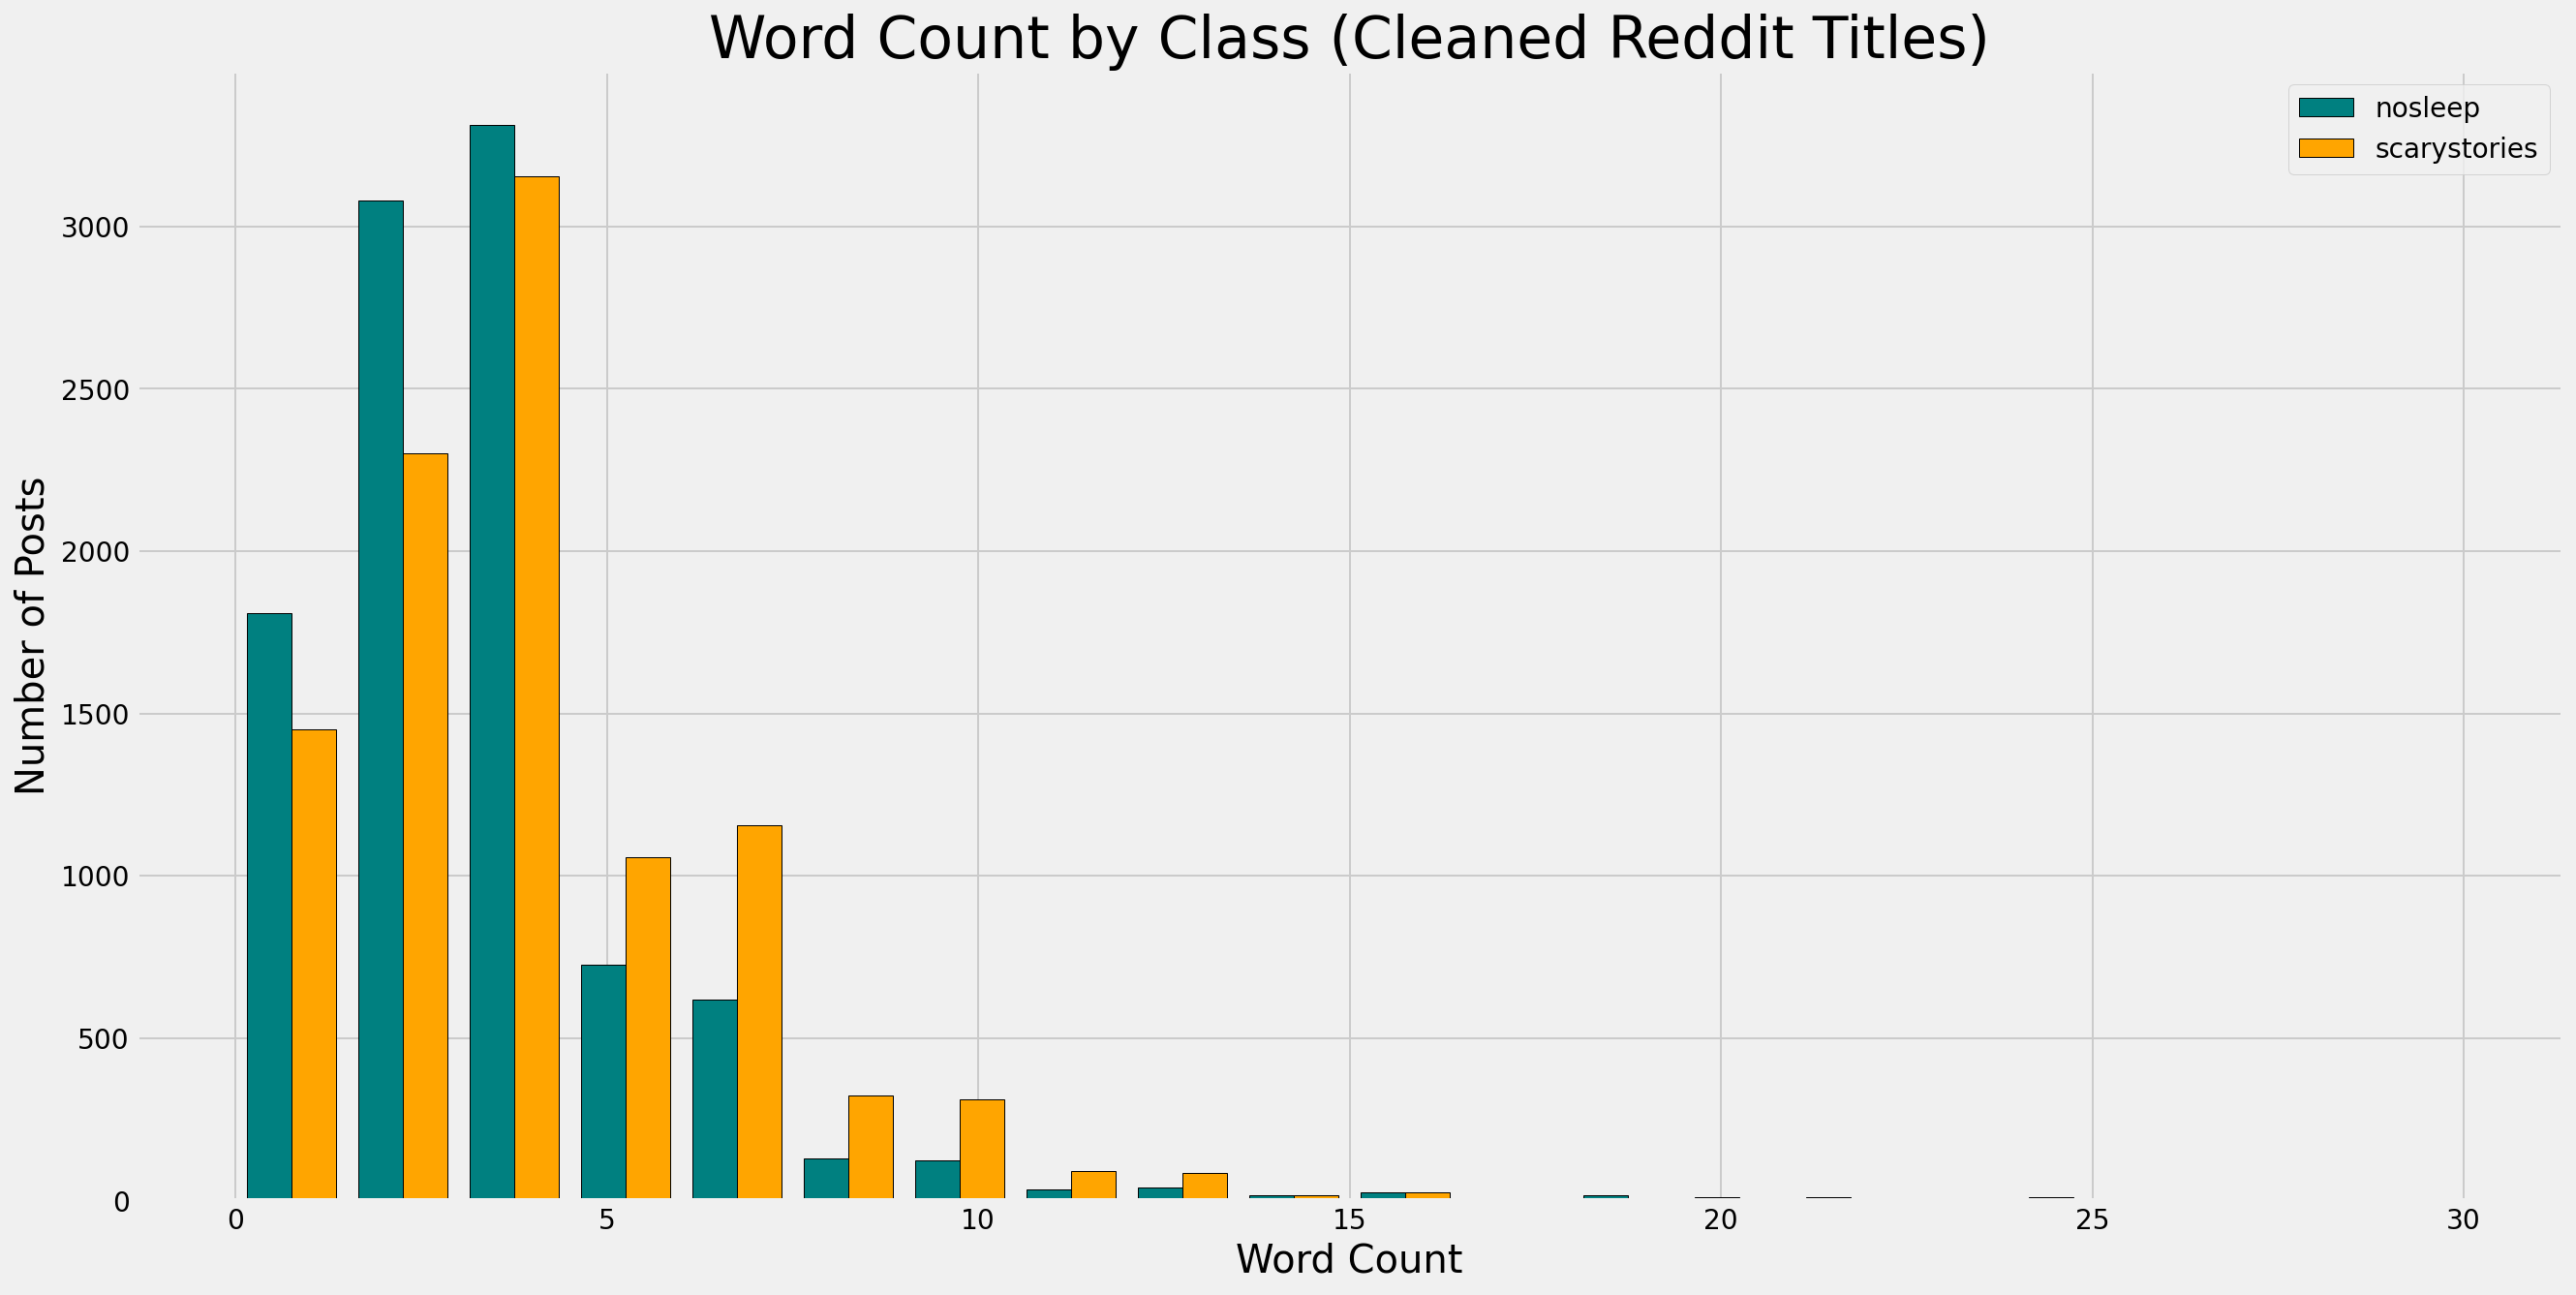

In [40]:
plt.figure(figsize=(20,10))
plt.hist([df[df['subreddit']==0]['clean_title_word_count'], 
          df[df['subreddit']==1]['clean_title_word_count']],
         bins=20, color=['teal', 'orange'], ec='k')
plt.title('Word Count by Class (Cleaned Reddit Titles)', fontsize=30)
plt.legend(['nosleep', 'scarystories']);

plt.xlabel('Word Count', fontsize=20)
plt.ylabel('Number of Posts', fontsize=20)

plt.savefig('../assets/clean_title_wordcount', bbox_inches='tight', dpi = 235);

**Discription: Word count distribution of cleaned subreddit titles separated by class (nosleep or scarystories)**

### Visualization of Cleaned Selftext Word Counts

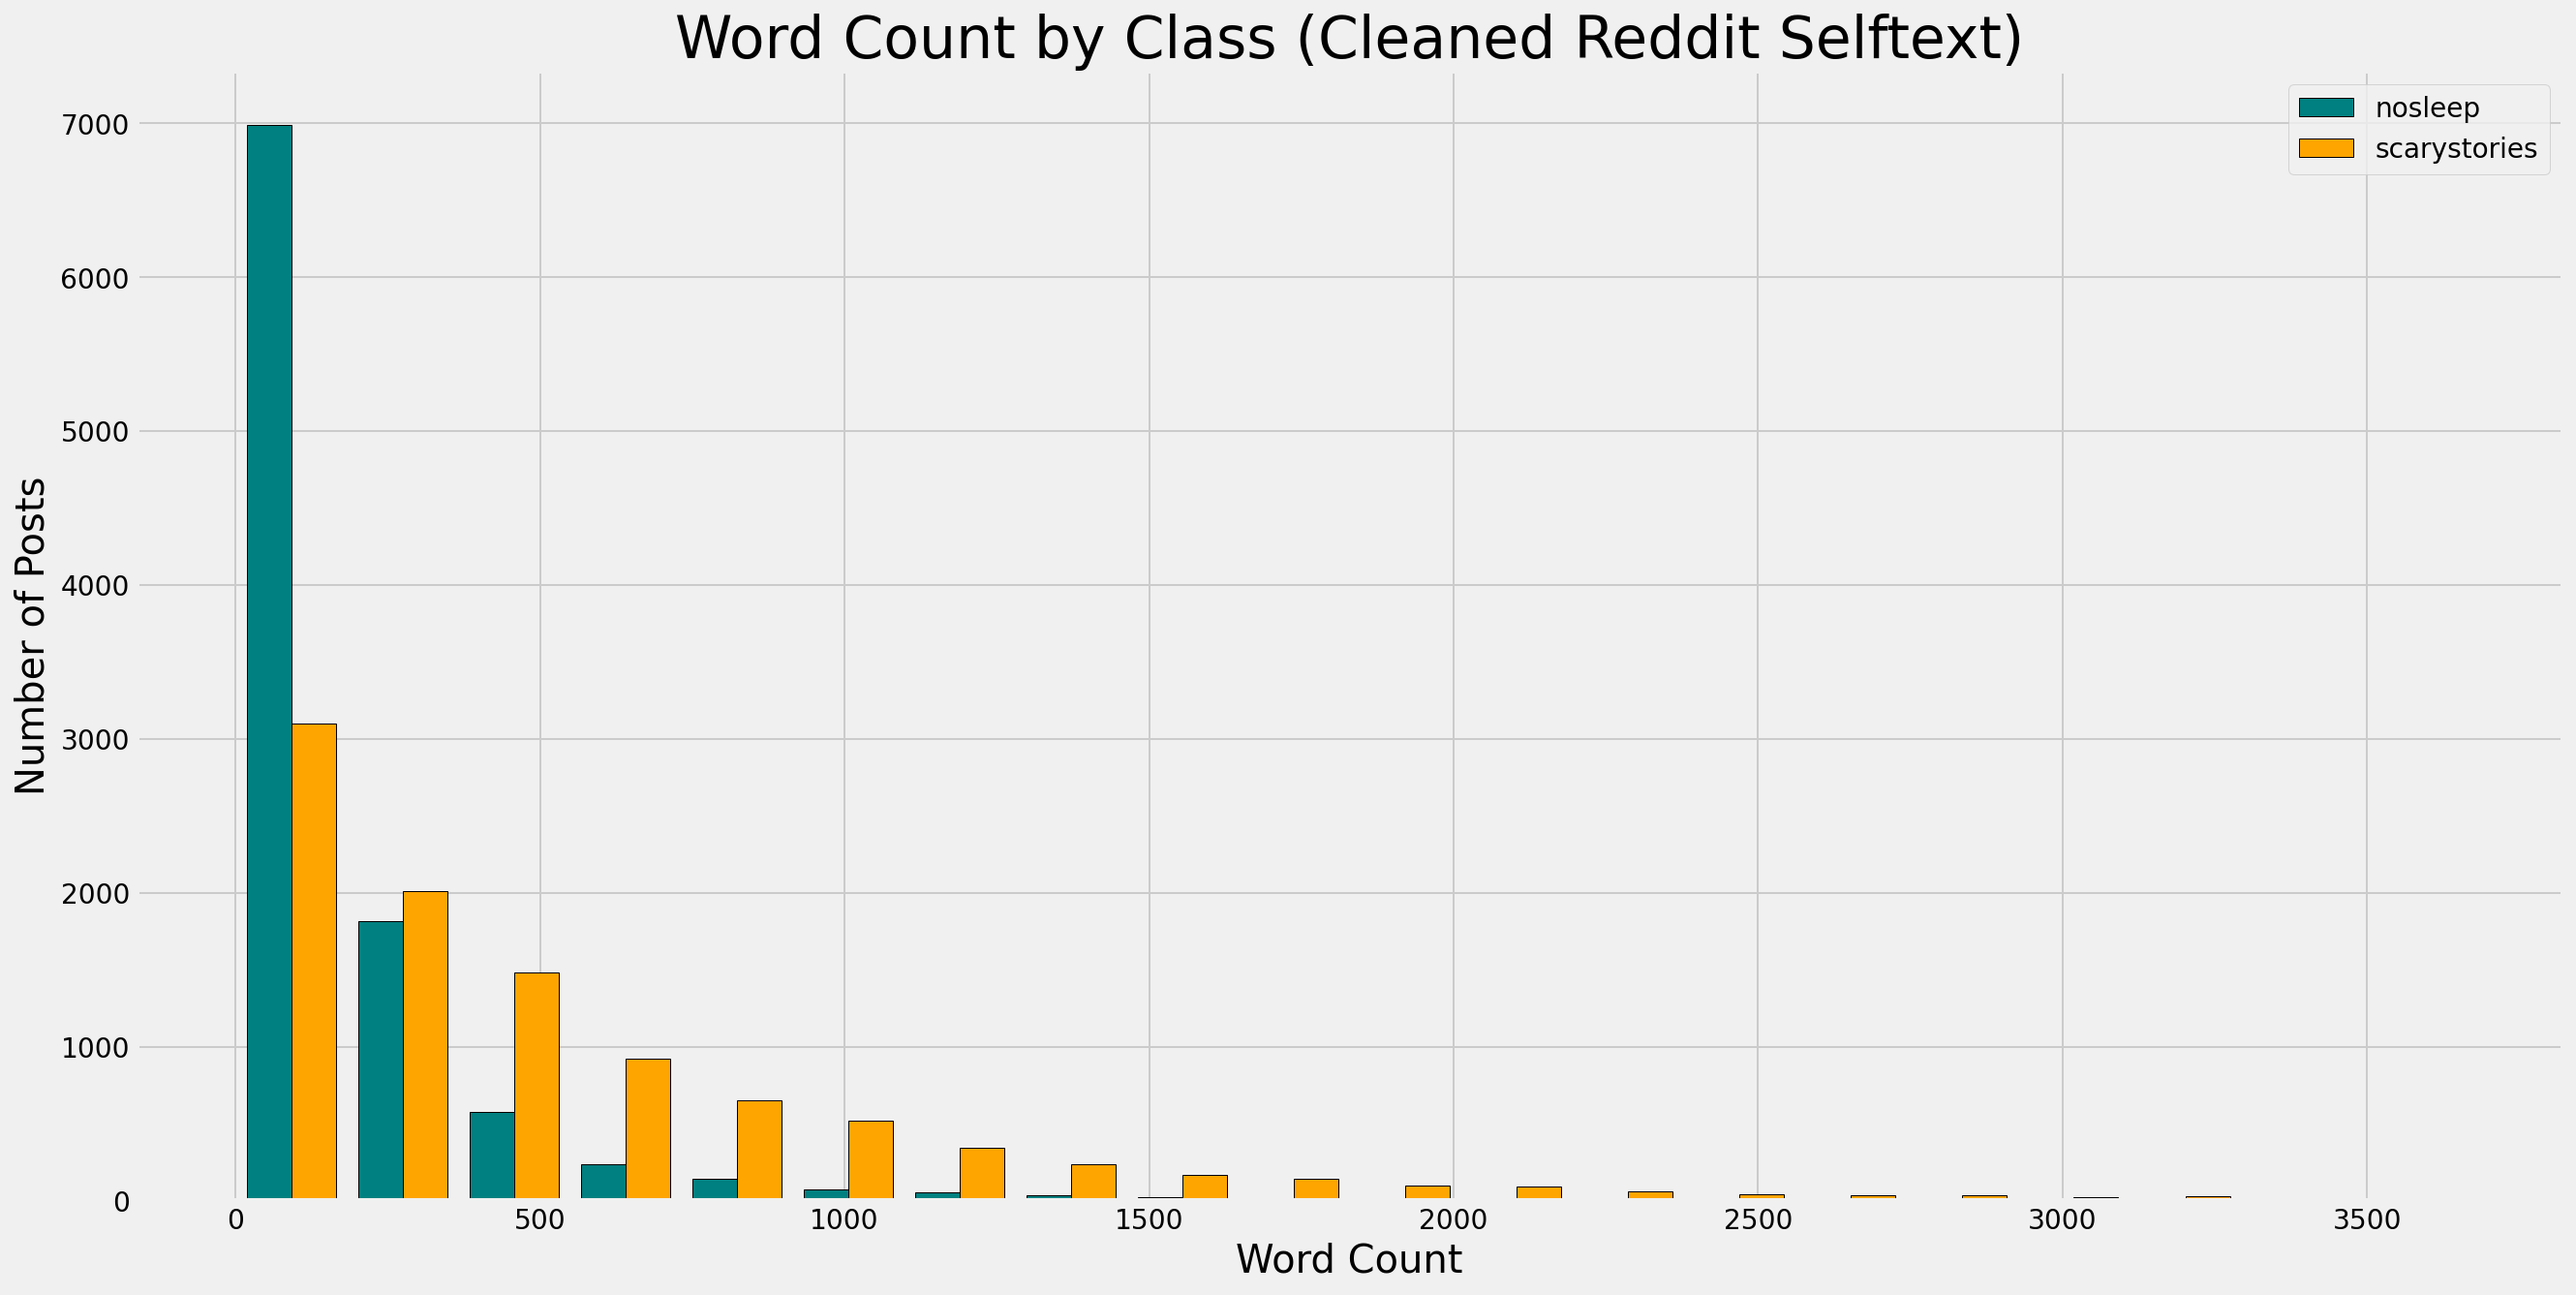

In [41]:
plt.figure(figsize=(20,10))
plt.hist([df[df['subreddit']==0]['clean_selftext_word_count'], 
          df[df['subreddit']==1]['clean_selftext_word_count']],
         bins=20, color=['teal', 'orange'], ec='k')
plt.title('Word Count by Class (Cleaned Reddit Selftext)', fontsize=30)
plt.legend(['nosleep', 'scarystories']);

plt.xlabel('Word Count', fontsize=20)
plt.ylabel('Number of Posts', fontsize=20)

plt.savefig('../assets/clean_selftext_wordcount', bbox_inches='tight', dpi = 235);

**Discription: Word count distribution of cleaned subreddit selftext separated by class (nosleep or scarystories)**

### Takeaway from Raw Data Distributions: 
**We can see that on average, around 50% of title and selftext data was removed through the cleaning process meaning only 50% of the original data was considered meaningful**


#### Create all content column by combining cleaned title and cleaned selftext data into one column

In [42]:
df['all_content'] = df['clean_title'] + ' ' + df['clean_selftext']

In [43]:
df['clean_content_word_count'] = df.selftext.map(lambda x: len(x.split()))

In [44]:
df[['all_content', 'clean_content_word_count']]

,all_content,clean_content_word_count
0,rules surviving crack rewrite possibility rewr...,1138
1,followed home night got tape morning warm nigh...,505
2,t looking door seven thirteen fourteen sixteen...,2810
3,prisoner special security prison recently let ...,2631
4,friend told scary story years ago haunts day y...,812
...,...,...
19995,nd did days seen dog creature standing legs ju...,357
19996,conspiracy theory isn t scary s little bit blo...,86
19997,scariest dark web stories notext,1
19998,prologue steve woke middle night sweat drippin...,277


In [45]:
df.to_csv('../datasets/preprocessed_data.csv')